In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
import scipy.integrate as integ

from astropy.modeling.models import BlackBody
from astropy.modeling.blackbody import blackbody_lambda
from astropy.modeling.blackbody import blackbody_nu

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

#plt.rc('figure', figsize=(10, 8)) # Larger figure sizes

# Project 3: "La Palma": Anatomy of a sunspot

#### Candidate numbers: ? and ?

What are sunspots? This is a question scientiests still ask, and phenomenons we try to learn more about. 
We want to use spectral observations of the Sun, taken at the Roque de Los Muchachos Observatory with the Swedish 1-m Solar Telescope (SST) at La Palma, in order to learn more about sunspots. Among other things, we want to determine the parameters of the atmosphere, investigate brightness temperature, velocities, and magnetic fields, in order to tell us more about the sunspot, how it compares with the solar granulation around, and its properties. Why are they dark? Are they colder than their surroundings? These are some of the questions we hope to answer after analysing these observations.


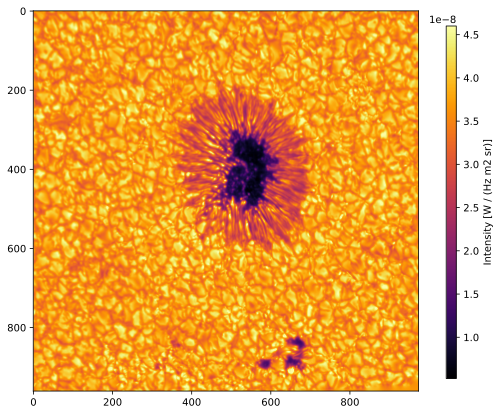

In [21]:
# FRA OPPGAVEN: KAN HA MED
fig, ax = plt.subplots(figsize=(7,7))
im_I = ax.imshow(data['intensity'][0].value, vmax=4.6e-8, cmap='inferno');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_I, cax=cbar_ax)
cbar.set_label("Intensity [W / (Hz m2 sr)]",size=10)
plt.show()

Beskrive hva som finnes av ulike områder, granulations, lanes, pores, manke.. Mindre lys, beskrive hva vi ser. Prøve å koble inn det vi sil se på og undersøke, derfor vi vil 
intensitet for en spesifikk bølgelengde ser vi her
temp vil være naturlig, er intensitet såpass lav og høy for alle bølgelengder, siden boltzmann B går som I og $B_{\nu}$ avhegner av T så er det naturlig å se på temp for alle bølgelengder, for å se om det er en sammenheng. 

The earth is 73.79 percent the size of the sunspot


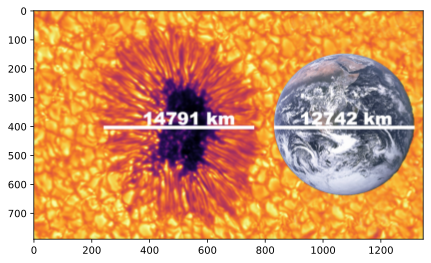

In [23]:
#earth size compared to earth:
area_sunspot = np.pi * (175*42.46)**2
area_eart = 128000000
precent = (area_eart*100) / area_sunspot
print("The earth is %.2f percent the size of the sunspot" %precent)

from PIL import Image
sunspot_earth = Image.open("sunspot_earth2.png")
fig, ax = plt.subplots(figsize=(7,7))
im_scale = ax.imshow(sunspot_earth);
plt.show()

Mer beskrivelse, strl forhold osv.. ser på bildet.
Vi kan vise med instensitet, inlede til plott under..

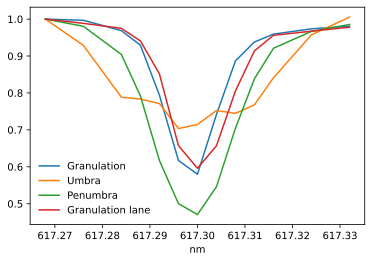

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(lam, intensity[:, 200, 200]/intensity[0, 200,200], label='Granulation') #bobler rundt
ax.plot(lam, intensity[:, 400, 550]/intensity[0, 400, 550], label='Umbra') #midten
ax.plot(lam, intensity[:, 400, 450]/intensity[0, 400, 450], label='Penumbra') #"manken"
ax.plot(lam, intensity[:, 800, 200]/intensity[0, 800, 200], label='Granulation lane')
ax.legend();

Beskrive hva vi ser i dette plottet. bla bla innlede til temp. 

First, we want to find the surface temperature $T_b$ and the velocities, in order to investigate the dynamics of the solar granulation, the granules and the inter-granular lanes, and how they are moving in relation to us. We start by finding $T_b$.
If we look at the frequency related Planck function

\begin{align}
B_{\nu}(T) = \frac{2 h \nu^3}{c^2} \frac{1}{e^{\frac{h \nu}{k_B T} - 1}},
\end{align}

the brightness temperature is the temperature which needs to be implemented into this expression, in order to be able to say

\begin{align}
B_{\nu}(T_b) = I_{\nu}^{\text{obs}},
\end{align}

where $I_{\nu}^{\text{obs}}$ is the observed intensity. We assume that the body radiates as a black body, so we can also assume that $I_{\nu} \propto B_{\nu}$, and  that $T_b$ is the same for all frequencies. This means that $T_b$ from continuum frequencies(stemmer?) are more likely to be close to the effective temperature of the star, which indicates that we can use $I_0$ and $\lambda_0$ when calculating $T_b$.


From the observations, we get values for the intensity [W / (Hz m2 sr)], Stokes V (circular polarisation) [W / (Hz m2 sr)] and the wavelength [nm]. There are 13 wavelengths, roughly covering the FeI 617 nm line profile, and we want to use $\lambda_0 = 617.300$ nm as the rest wavelength.
When looking at Eq.(1) and assuming radiation from a black body, we already know the intensity $I_{\nu}^{\text{obs}}$ from the observations, and we can easy find the frequency $\nu$ values by use of the wavelength values from the observations, so we need to rewrite Eq.(1) in order to find $T_b$. By rewriting, we obtain

\begin{align}
T_b = \Big( \text{ln} \Big( \frac{2h \nu^3}{c^2 I_{\nu}}  +1 \Big) \frac{k}{h \nu} \Big)^{-1}
\end{align}


In order to solve this we first need to read the observations from file. Then, by use of constants collected from $\verb|astropy|$ and Eq.(3) we find the brightness temperature. We then create a plot in order to observe the temperature in the sunspot, granulation and the pores.


In [3]:
# Define variables:
e = constants.e
c = constants.c
m_e = constants.m_e
k_B = constants.k_B
h = constants.h
g_ = 2.499      #effective Landé factor


# Read observations from data set:
data = QTable.read('SST_sunspot_617_2020.08.07.fits')
Stokes_V = data["stokes_v"]
intensity = data["intensity"]
lam = data["wavelength"]           #observed Doppler-shifted wavelength
lam0 = 617.300 * units.nm          #rest wavelength

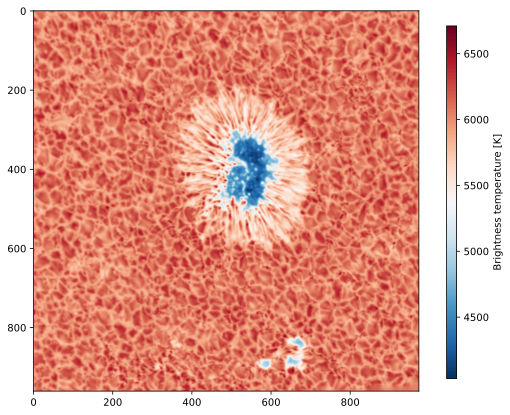

In [4]:
# Brightness temperature: MÅ MED

def T_b(): 
    T_brightness = 1 / (np.log((2*h*((c/lam[0])**3))/(c**2 * intensity[0])/units.sr + 1) * (k_B / (h*(c/lam[0]))))
    return T_brightness.to("K")

fig, ax = plt.subplots(figsize=(7,7))
im1 = ax.imshow(T_b().value, cmap='RdBu_r');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)

cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Brightness temperature [K]",size=10)
plt.show()


In the plot presented above, visualizing the brightness temperature, we observe that the temperature of the whole sunspot (including the umbra and the surrounded penumbra) is lower than the brightness temperature of the granulation. We also observe that the brightness temperature in the umbra is lower than in the penumbra, and that the temperature of the pores in the bottom right corner, also is lower than the temperature in the granulation, but the smaller pores have no sort of surrounded penumbra, and though their temperatures are low, they are not as low as the umbra's temperature. 



((Ta bort: Det er mye varmere rundt sunspot enn i sunspot. Det er varmere i penumbra enn i umbra, varemere i granulation enn i granulation lanes. We also observe some cold spots in the bottom right corner - pores, de er varmere enn umbra, men fremdeles kaldere enn granulation og gran lanes. )

Next, we want to calculate the velocity in order to interpret how the matter is moving in relation to us.  We need to take the shiftning of the velocity that occurs due to the Doppler effect into account, represened by the general formula

\begin{align}
\frac{ \lambda_0 - \lambda}{\lambda_0} = \frac{\Delta \lambda}{\lambda_0} = \frac{v}{c}.
\end{align}
where $\lambda$ is the Doppler shiftet wavelength, and $v$ is the velocity of the body. This formula is useful, since spectral lines also gets Doppler shiftet, so by finding the shiftet wavelength from the shiftet spectral line and by use of the Doppler shift equation, we can determine the velocity, which in our case will be the velocty along the line of sight, $v = v_{\text{los}}$, which can be. By use of this definition, a negative velocty indicates that the body is moving away from us, 

Using this definition, a positive  𝑣  means a blue-shift (meaning the body is moving towards us), and a negative  𝑣  means a red-shift (moving away from us). 





the plot and find out if there is a connection between the tempearture and ... forklare hvorfor vi må tenkte på doppler, og bevegelsen osv. og innlede hva vi gjør i koden



Finner først theta, vinkel mellom v_los and v. Så finner vi mu, som er bølgelengden der spektrallinjen har sin peak. 

In [5]:
#FINNER THETA:

alpha = np.sqrt((248**2) + (473**2)) / (3600*360)*2*np.pi #angle between us and sunspot
y = constants.au * alpha #height of sunspot

theta = np.arcsin(y/constants.R_sun) #angle between v and v_los

cos_theta = np.cos(theta)

In [6]:
#integral_1 = np.zeros(data["intensity"][0].shape)
#integral_2 = np.zeros(data["intensity"][0].shape)
#intensity = np.zeros(data["intensity"].shape)

#for i in range(len(data["intensity"])):
#    intensity[i] = data["intensity"][0].value - data["intensity"][i].value

#for i in range(len(data["intensity"][0])):
#    for j in range(len(data["intensity"][0][0])):
#        integral_1[i, j] = integ.trapz(data["wavelength"].value * intensity[:, i, j], data["wavelength"].value)
#        integral_2[i, j] = integ.trapz(intensity[:, i, j], data["wavelength"].value)
#mu = integral_1 / integral_2
#np.save("mu.npy", mu)

In [7]:
mu = np.load("mu.npy")
lam_new =  mu * units.nm

TEKST

In [8]:
# Line of sight velocity:
def v_los(lam0, lam_new): 
    v_lineofsight = c * ((lam0 - lam_new)/lam0)
    return v_lineofsight.to("km/s")


#fig, ax = plt.subplots(figsize=(7,7))
#im_vlos = ax.imshow(v_los(lam0, lam_new), cmap='RdBu');
#cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
#cbar_ax.tick_params(labelsize=10)
#cbar = fig.colorbar(im_vlos, cax=cbar_ax)
#cbar.set_label("Line of sight velocity [km/s]",size=10)
#plt.show()


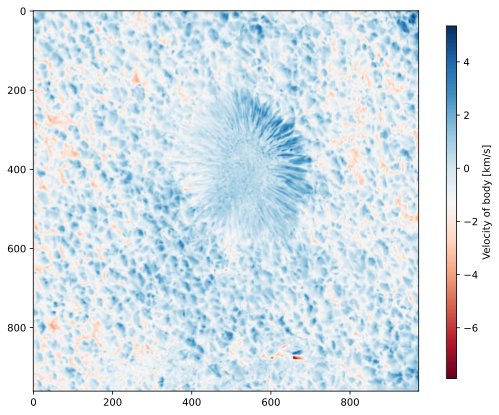

In [9]:
#MÅ HA MED, faktiske hastigheten.
# Velocity:

def v(v_los,cos_theta): 
    velocity = v_los/cos_theta
    return velocity


fig, ax = plt.subplots(figsize=(7,7))
im_v = ax.imshow(v(v_los(lam0, lam_new),cos_theta), cmap='RdBu');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_v, cax=cbar_ax)
cbar.set_label("Velocity of body [km/s]",size=10)
plt.show()


v: I granulation så beveger materien the matter towrad us, while in the granulation lanes, beveger det seg fra oss. Dette gir mening i forhold til at vi vet at det skjer convection, which means hot matter rises towards the surface while it cools down bla bla.. 

In the umbra, OG prenumbra, så beveger hele solflekken seg mot oss. 

Ser ut som høyresiden av sunspot har en høyere hastighet rettet ut fra overflaten. Grunnen til det??

In [10]:
#Find the variance sigma^2:

#integral_3 = np.zeros(data["intensity"][0].shape)
#integral_4 = np.zeros(data["intensity"][0].shape)
#intensity = np.zeros(data["intensity"].shape)

#for i in range(len(data["intensity"])):
#    intensity[i] = data["intensity"][0].value - data["intensity"][i].value
    
#for i in range(len(data["intensity"][0])):
#    for j in range(len(data["intensity"][0][0])):
#        integral_3[i, j] = integ.trapz( ((data["wavelength"].value - mu[i,j])**2) * intensity[:, i, j], data["wavelength"].value)
#        integral_4[i, j] = integ.trapz(intensity[:, i, j], data["wavelength"].value)
#sigma2 = integral_3 / integral_4
#np.save("sigma2.npy", sigma2)

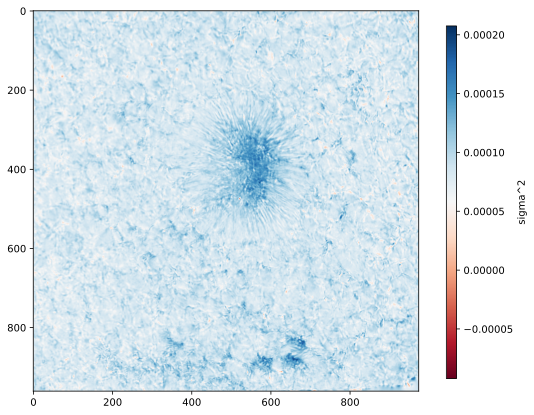

In [11]:
sigma2 = np.load("sigma2.npy") * units.nm #LURT Å HA MED, broadning, zeeman effec

fig, ax = plt.subplots(figsize=(7,7))
im_sigma = ax.imshow(sigma2, cmap='RdBu');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_sigma, cax=cbar_ax)
cbar.set_label("sigma^2",size=10)
plt.show()

mer broadening i sunspot center og i pores enn generelt andre steder, kan ikke se mye annet fra det bildet. Det kan vi sammenligne med etterpå. 

In [12]:
#B-felt, HA MED

#dI_dl = np.zeros(data["intensity"].shape)
#for i in range(len(data["intensity"][0])):
#    for j in range(len(data["intensity"][0][0])):
#        dI_dl[:, i, j] = np.gradient(intensity[:, i, j], data["wavelength"].value)

#B = -4*np.pi*m_e*c / constants.e.si*g_* lam0**2 * np.sum(dI_dl * data["stokes_v"], axis = 0) / np.sum(dI_dl**2, axis = 0)

#np.save("B.npy", B.value)

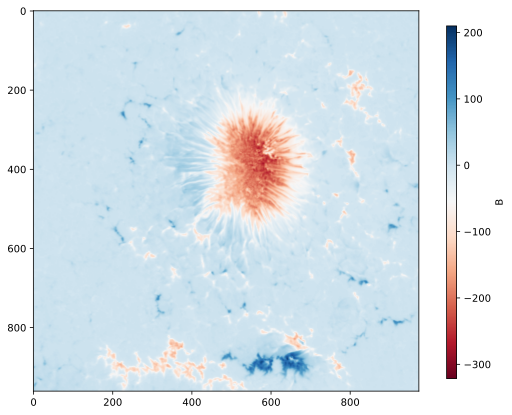

In [13]:
B = np.load("B.npy") / cos_theta

fig, ax = plt.subplots(figsize=(7,7))
im_B = ax.imshow(B, cmap='RdBu');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_B, cax=cbar_ax)
cbar.set_label("B",size=10)
plt.show()


((kommentar: Broadning av linja blir. Linja blir breiere der det er større magnetfelt, noe som gjør at det blir observert mye mer lys her enn ellers hvor magnetfeltet er lavere, og det er derfor sunspoten er så mye mørekere enn surroundings.)

In [14]:
#HA MED
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(7,7))
p = ax.imshow(B, cmap = "RdBu")
#q = ax.imshow(data['stokes_v'][4].value, cmap='RdBu')
#q = ax.imshow(data['intensity'][4].value, cmap='RdBu')
q = ax.imshow(sigma2.value, cmap='RdBu')

anim = ArtistAnimation(fig, [[p], [q]], interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

In [15]:
#HA MED
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(7,7))
p = ax.imshow(T_b().value, cmap = "RdBu")
q = ax.imshow(v(v_los(lam0, lam_new),cos_theta).value, cmap='RdBu')

anim = ArtistAnimation(fig, [[p], [q]], interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

Diskuterer og drøfter og sammenligner det vi ser. Grunner til hvorfor ting er sånn.. osv





#KLADD::::



$I_{\lambda} = I_0$
#antar at legemet stråler som black body, så derfor kan vi at I_lam = I_0, da er det ikke no dupp. generell forklaring av I_lam

Vi har at I=B, så vi finner brightness temp ved å si at B=I og så henter vi ut bølgelengde og frekvens fra observasjoner og løser for T.
Using spectral velocities and brightness temperatures, what can you tell about the dynamics of the solar granulation? Which is cooler: the granules or the inter-granular lanes? How are they moving in relation to us?